In this notebook, I show how to implement "minibatches", a method which stores gradients over several chunks of data ("mini" batch) and apply them altogether. To keep this exercise concise, I use the MNIST image set and a very simple neural network as an example. I will compare how the results differ when the network is trained with and without minibatches, for several popular optimizers.

In [1]:
import tensorflow as tf # I use version 1.4
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, seed=123)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Build a toy network
For simplicity, we will build a simple (single-layer) fully connected feed-forward neural network. `x` is the input data placeholder for an arbitrary batch size (784 = 28x28 is MNIST image size). `W` and `b` are weights and biases for the output layer, and `y` is the output to be compared against the label. For MNIST (10 digit classification), let's use the softmax cross entropy as our loss function.

In [2]:
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.matmul(x, W) + b
y_ = tf.placeholder(tf.float32, [None, 10])

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

## Data preparation
We will use this simple function to load and store data prior to entering the training loop. This allows us to remove randomness in data-fetching, so that we can compare training with and without minibatches on the same dataset. Note that `shuffle=False` so that data is not randomly shuffled and we seed `read_data_sets` for reproducibility (in the first cell).
NOTE: the shuffle argument is available as of Tensorflow v1.3.

In [3]:
def get_images(batch_size, n_iterations):
    return [mnist.train.next_batch(batch_size = batch_size, shuffle=False) for _ in range(n_iterations)]

## Standard (no minibatch) training
Define a function `train-standard` that uses the optimizer's `minimize` function with the minimization target as an argument. There is no minibatch involved here. Note we seed the initialization of all variables.

In [4]:
def train_standard(opt_type, learning_rate, image_set):
    # Arrays for logging accuracy and loss
    acc_log = np.zeros(len(image_set))
    loss_log = np.zeros(len(image_set))
    # Create optimizer
    opt = opt_type(learning_rate)
    #
    # no-minibatch (standard, simple) operation
    #
    minimize = opt.minimize(loss)
    # Create session to execute ops
    sess = tf.InteractiveSession()
    # Necessary initializations
    tf.set_random_seed(1234)
    tf.global_variables_initializer().run()
    # Train loop
    for i, batch in enumerate(image_set):
        sess.run(minimize, feed_dict={x: batch[0], y_: batch[1]})
        
        acc_log[i] = sess.run(accuracy, 
                              feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        loss_log[i] = sess.run(loss, 
                               feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        
    return acc_log, loss_log

## Minibatch training
Define `train_minibatch` function and implement asynchronous weight updates. The idea is to accummulate gradients across a batch-worth of minibatches, then apply the accummulated gradients to update the parameters. One should not forget to _nullify_ (i.e. set to zero) the gradients when starting on a new batch. Note we set the same random number generator seed as `train_standard`. Much of this implementation was taken from [this](https://stackoverflow.com/a/42222976/5507784) Stack Overflow post.

In [5]:
def train_minibatch(opt_type, learning_rate, image_set, minibatch_size):
    # Arrays for logging accuracy and loss
    acc_log = np.zeros(len(image_set))
    loss_log = np.zeros(len(image_set))
    # Create optimizer
    opt = opt_type(learning_rate)
    #
    # minibatch operations
    #
    # 0) Retrieve trainable variables
    tvs = tf.trainable_variables() 
    # 1) Create placeholders for the accumulating gradients we'll be storing
    accum_vars = [tf.Variable(tv.initialized_value(),
                  trainable=False) for tv in tvs]
    # 2) Operation to initialize accum_vars to zero
    zero_ops  = [tv.assign(tf.zeros_like(tv)) for tv in accum_vars]
    # 3) Operation to compute the gradients for one minibatch
    gvs = opt.compute_gradients(loss)
    # 4) Operation to accumulate the gradients in accum_vars
    accum_ops = [accum_vars[i].assign_add(gv[0]) for i, gv in enumerate(gvs)]
    # 5) Operation to perform the update (apply gradients)
    apply_ops = opt.apply_gradients([(accum_vars[i], tv) for i, tv 
                                     in enumerate(tf.trainable_variables())])
    # Create session to execute ops
    sess = tf.InteractiveSession()
    # Necessary initializations
    tf.set_random_seed(1234)
    tf.global_variables_initializer().run()
    # Train loop
    for i, batch in enumerate(image_set):
        # Make sure gradients are set to 0 before entering minibatch loop
        sess.run(zero_ops)
        # Loop over minibatches and execute accumulate-gradient operation
        for j in range(len(image_set) / minibatch_size):
            sess.run(accum_ops, 
                     feed_dict={x: batch[0][j*minibatch_size:(j+1)*minibatch_size],
                                y_: batch[1][j*minibatch_size:(j+1)*minibatch_size]})

        # Done looping over minibatches. Now apply gradients.
        sess.run(apply_ops)
        
        acc_log[i] = sess.run(accuracy, 
                              feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        loss_log[i] = sess.run(loss, 
                               feed_dict={x: mnist.test.images, y_: mnist.test.labels})

        #print("in iteration {}".format(i), sess.run(accum_vars))
    return acc_log, loss_log

## _main_ function
We are almost there! Let's now define our _main_ function that does the comparison between `train_standard` and `train_minibatch` methods. Here we define a set of optimizers, try the comparison for each optimizer independently. We use the network's loss and accuracy as a comparison metric.

In [6]:
def compare(batch_size, minibatch_size, n_iterations):

    # Define optimizers (type, learning rate, and name) to be compared
    options = { tf.train.GradientDescentOptimizer : (0.03,  "SGD"),
                tf.train.AdagradOptimizer         : (0.001, "Adagrad"),
                tf.train.AdamOptimizer            : (0.001, "Adam"),
                tf.train.RMSPropOptimizer         : (0.0001,"RMSProp")
              }

    # Load a fixed set of images to run the training on
    image_set = get_images(batch_size=batch_size, n_iterations=n_iterations)

    # Loop over optimizers to compare
    for opt_type, (lr,name) in options.iteritems():
        # Canvas making
        f, (ax0,ax1) = plt.subplots(1,2,figsize=(16,4),sharey=False,facecolor='w')
        f.suptitle('{} Batch {}'.format(name,batch_size), fontsize=20, fontname="Georgia")

        # accuracy plot
        ax0.set_ylabel("accuracy",fontsize=20,fontname="Georgia")
        ax0.set_xlabel("iterations",fontsize=20,fontname="Georgia")
        # loss plot
        ax1.set_ylabel("loss",fontsize=20,fontname="Georgia")
        ax1.set_xlabel("iterations",fontsize=20,fontname="Georgia")
        
        # "standard" training first
        acc_log, loss_log = train_standard  (opt_type=opt_type, 
                                             learning_rate=lr, 
                                             image_set=image_set)
        ax0.plot(acc_log,  'r.-', label="No minibatch")
        ax1.plot(loss_log, 'r.-', label="No minibatch")
        
        # "minibatch" training second
        acc_log, loss_log = train_minibatch (opt_type=opt_type, 
                                             learning_rate=lr, 
                                             image_set=image_set, 
                                             minibatch_size=minibatch_size)
        ax0.plot(acc_log, 'b', label="Minibatch {}".format(minibatch_size))
        ax1.plot(loss_log,'b', label="Minibatch {}".format(minibatch_size))

        # Show
        ax0.grid()
        ax1.grid()
        ax0.legend(loc=4,fontsize=16)
        ax1.legend(loc=3,fontsize=16)
        plt.show()

## Test 0
It is important to demonstrate that this implementation for ONE minibatch is equivalent to the no-minibatch (i.e. standard) implementation. To perform this test, we set `minibatch_size` and `batch_size` the same value.

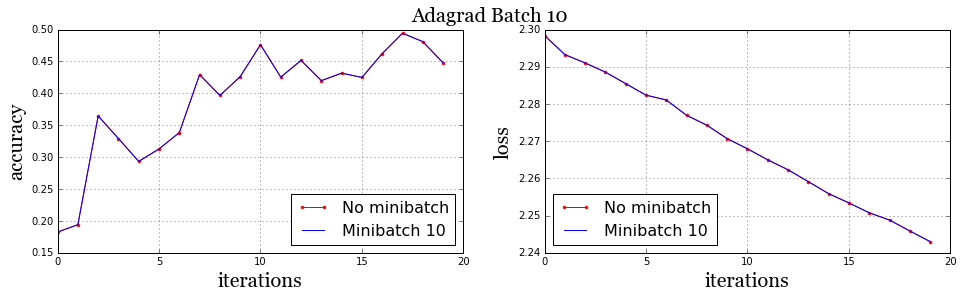

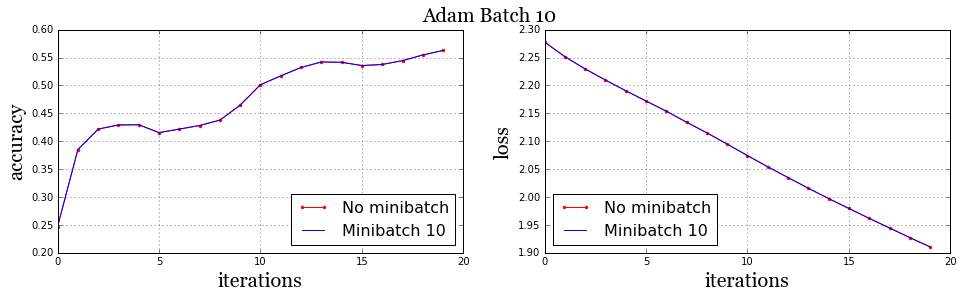

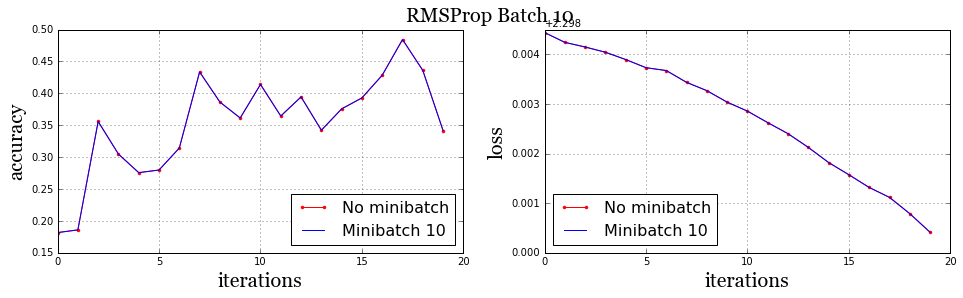

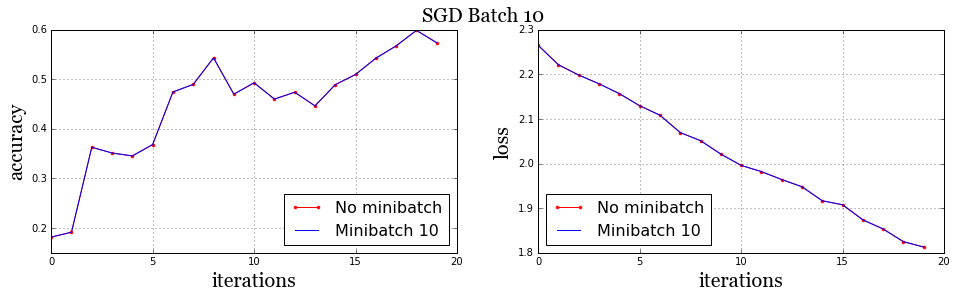

In [7]:
compare( batch_size     = 10,
         minibatch_size = 10,
         n_iterations   = 20)

This looks great = what we expected. 

## Test 1
Next, let's see what happens if we enable the minibatch option by setting `minibatch_size` and `batch_size` 5 and 10, respectively. This means there will be 2 minibatches in the minibatch implementation. 

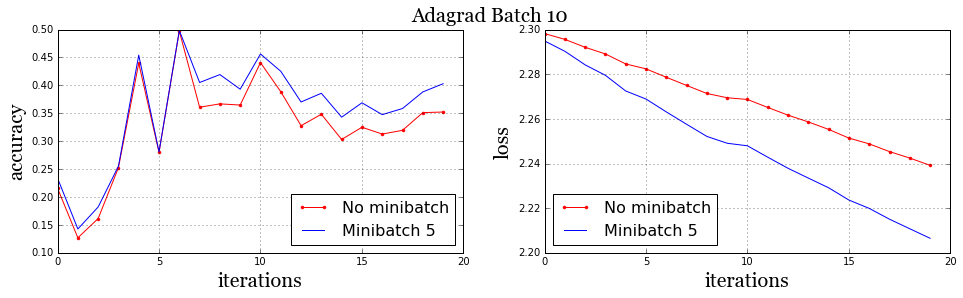

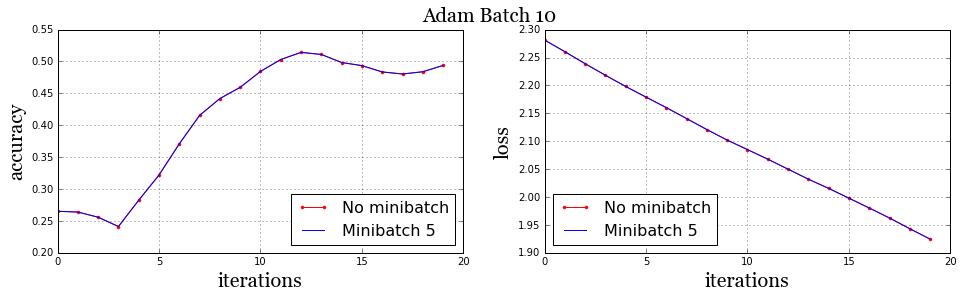

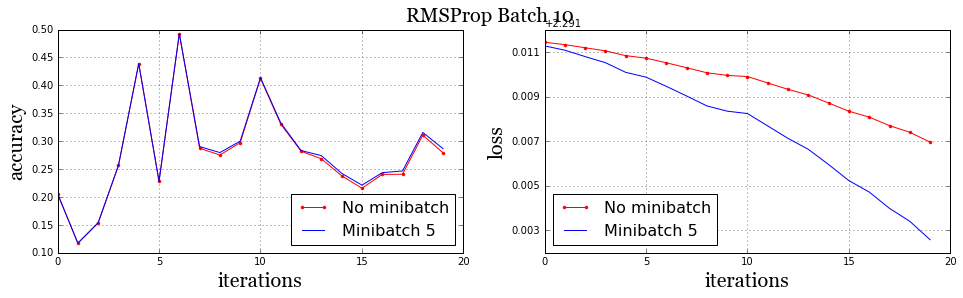

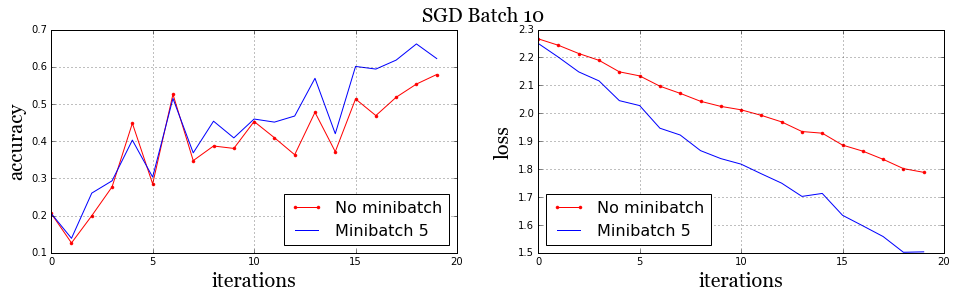

In [8]:
compare( batch_size     = 10,
         minibatch_size = 5,
         n_iterations   = 20)

The results are more interesting than the previous test. For AdamOptimizer, it shows two methods are effectively identical. This is what we would expect naturally unless there is a dynamic state of an optimizer, which changed during minibatch loop. It turns out this is the case for the three other optimizers we tested here. So we do expect red and blue not to completely overlap. However, for all those methods, the state shift is designed to help the gradient applications. This is why using minibatches ends up with a _better_ result, i.e. loss curve of minibatch method (blue) almost always resides below no-minibatch method (red).

In this notebook we exercised how to implement minibatches in TensorFlow. You can `git clone` this notebook from [Ji Won's repository](https://github.com/jiwoncpark/deep-learning).